# k-Nearst Neighbor

In [28]:
# Set up Notebook

%matplotlib inline

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from matplotlib import cm
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors

# We do this to ignore several specific warnings
import warnings
warnings.filterwarnings("ignore")

sns.set(style="white")

In [29]:
iris = sns.load_dataset("iris")
iris.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,species
105,7.6,3.0,6.6,2.1,virginica
52,6.9,3.1,4.9,1.5,versicolor
138,6.0,3.0,4.8,1.8,virginica
0,5.1,3.5,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


In [30]:
data = iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values
labels = np.array([i//50 for i in range(iris.shape[0])])
frac = 0.4

In [31]:
# We want to split our data into training and testing
# Note that we have both 'data' and 'labels'
d_train, d_test, l_train, l_test = train_test_split(data, 
                                                    labels, 
                                                    test_size=frac, 
                                                    random_state=23)
    
# Now scale our data
# Create and fit scaler
sc = StandardScaler().fit(d_train)


In [32]:
d_train_sc = sc.transform(d_train)
d_test_sc = sc.transform(d_test)

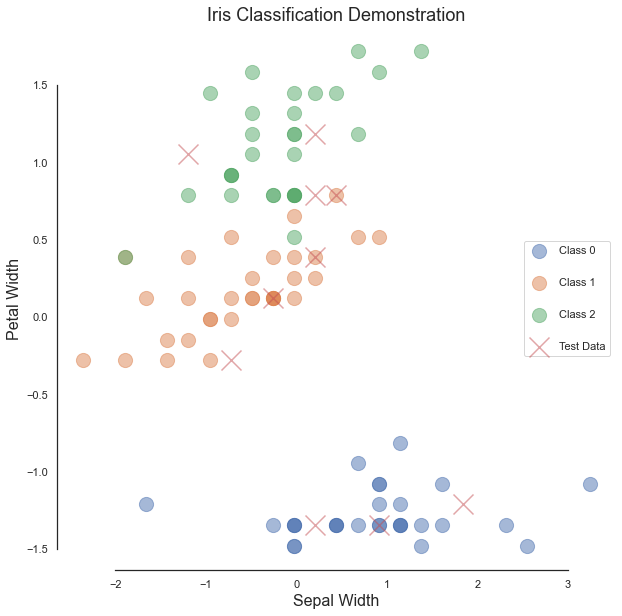

In [33]:
# Now we create our figure and axes for the plot we will make.
fig, ax = plt.subplots(figsize=(10, 10))

x = d_train_sc[:, 1]
y = d_train_sc[:, 3]
num_show = 10

for idx in np.unique(l_train):
    i = int(idx)
    ax.scatter(x[l_train == i], y[l_train == i], label=f'Class {i}',
                       s=200, alpha = .5, cmap=cm.coolwarm) 

xx = d_test_sc[:num_show, 1]
yy = d_test_sc[:num_show, 3]
ax.scatter(xx, yy, label='Test Data',
           marker='x', s=400, 
           alpha = .5, cmap=cm.coolwarm) 
        
# Decorate and clean plot
ax.set_xlabel('Sepal Width', fontsize=16)
ax.set_ylabel('Petal Width', fontsize=16)
ax.legend(loc = 7, labelspacing=2)
ax.set_title("Iris Classification Demonstration", fontsize=18)
sns.despine(offset=0, trim=True)

We can now apply the k-nn algorithm to the Iris data to create a classification model. The basic approach is simple, and follows the standard scikit-learn estimator philosophy:

1. Import the proper module, `neighbors`.
2. Create the estimator, `KNeighborsClassifier` and specify hyperparameters. In this case we need to specify the number of neighbors, but we can use the default weight, which is `uniform`.
3. Fit the model to the training data, note that by using our simple `get_iris_data` helper function we have loaded the Iris data, split the data into training and testing sets, and scaled all data by first normalizing the training data.
4. Predict new classes with our trained model (or in the simple demonstration below, generate a performance metric via the `score` method).

In [34]:
# The number of neighbors affects performance
nbrs = 5
# First we construct our model
knc = neighbors.KNeighborsClassifier(n_neighbors=nbrs)

# Now train our model
knc.fit(d_train_sc, l_train)

# Compute and display accuracy score
score = 100.0 * knc.score(d_test_sc, l_test)
print(f"KNN ({nbrs} neighbors) prediction accuracy = {score:5.1f}%")

KNN (5 neighbors) prediction accuracy =  96.7%


## Confusion Metrics

As previously demonstrated, we can call the `score` method on our k-nn classifier to compute and display a simple performance metric or value. In general however, there are a number of different  metrics that can be used to quantify the performance of a classification algorithm, and the `scikit-learn` prodes support to compute many of these metrics in the `metrics` module.

Another simple way to understand our performance is to create and display a `confusion matrix`. A confusion matrix has rows that correspond to the true labels and columns that correspond to the predicted labels. The elements of the confusion matrix contain the number of instances with true label given the row index and the predicted label by the column index.

In [35]:
from sklearn.metrics import confusion_matrix

# Generate predictions
l_pred = knc.predict(d_test_sc)

# Create and display confusion matrix
print(confusion_matrix(l_test, l_pred))

[[21  0  0]
 [ 0 18  0]
 [ 0  2 19]]


In this case, we see that the classifier only misclassifies two instances of Iris virginica as Iris versicolor. This type of visualization is a powerful technique to convey the performance of a machine classification.

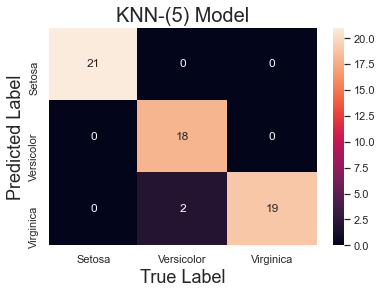

In [37]:
def confusion(test, predict, title):
    # Define names for the three Iris types
    names = ['Setosa', 'Versicolor', 'Virginica']

    # Make a 2D histogram from the test and result arrays
    # pts is essentially the output of the scikit-learn
    # confusion_matrix mathod
    pts, xe, ye = np.histogram2d(test, predict, bins=3)

    # For simplicity we create a new DataFrame for the confusion matrix
    pd_pts = pd.DataFrame(pts.astype(int), index=names, columns=names )
    
    # Display heatmap and add decorations
    hm = sns.heatmap(pd_pts, annot=True, fmt="d")
    hm.axes.set_title(title, fontsize=20)
    hm.axes.set_xlabel('True Label', fontsize=18)
    hm.axes.set_ylabel('Predicted Label', fontsize=18)

    return None

confusion(l_test, l_pred, f'KNN-({nbrs}) Model')

There are a number of other different scores, which one is most useful often depends on the nature of the classificatoin task.  
Commonly used scores are the *precision and the recall* and the *f1-score*, where the *f1-score* is simply the harmonic mean of the precision and the recall.

In the following code example, we also pass in a list of target names. If we didn't do this, the labels would simply be listed as Class 0, Class 1, and Class 2. In addition, the number of floating point digits (or the number of digits displayed past the decimal point) can be controlled by the `digit` parameter. Passing a large value, such as `4`, will distinguish between the Iris versicolor precision and Iris virginica recall.

In [38]:
from sklearn.metrics import classification_report

# Compute and display classification report
print(classification_report(l_test, l_pred, \
                            target_names = ['Setosa', 'Versicolor', 'Virginica']))

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        21
  Versicolor       0.90      1.00      0.95        18
   Virginica       1.00      0.90      0.95        21

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



## k-Nearest Neighbors: Hyperparameters

ML algorithms often have tuning parameters that are extrinsic to the algorithm that cannot be determined directly from the data being analyzed, these are known as *hyperparameters*.  
The k-nn algorithm has two hyperparameters: the number of nearest neighbors and a weighting scheme.

To demonstrate how these hyperparameters affect the performance of the k-nn algorithm the following subsection create a k-nn estimator with different values for theses hyperparameters and display the results.

### Neighbors

We start by varying the number of neighbors.

In [42]:
import utils

n_data = utils.trim_data(d_train_sc, l_train)

AttributeError: module 'utils' has no attribute 'trim_data'